In [3]:
# define import
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import numpy as np

# Data Loading Pre-processing

In [4]:
import pickle
import random

with open("text_classification_train_words", "rb") as f:
    train = pickle.load(f)

with open("text_classification_test_words", "rb") as f:
    test = pickle.load(f)

print(f"{len(train)} samples in train")
print(f"{train[random.randint(0, len(train) - 1)]}")
print(f"{len(test)} samples in test")
print(f"{test[random.randint(0, len(test) - 1)]}")
print(len(train[0]['text']))

25000 samples in train
{'id': '104', 'rating': 3, 'label': 0, 'text': "En route to a small town that lays way off the beaten track (but which looks suspiciously close to a freeway), a female reporter runs into a strange hitch-hiker who agrees to help direct her to her destination. The strange man then recounts a pair of gruesome tales connected to the area: in the first story, an adulterous couple plot to kill the woman's husband, but eventually suffer a far worse fate themselves when they are attacked by a zombie; and in the second story, a group of campers have their vacation cut short when an undead outlaw takes umbrage at having his grave peed on.<br /><br />The Zombie Chronicles is an attempt by writer Garrett Clancy and director Brad Sykes at making a zombie themed anthology\x97a nice idea, but with only two stories, it falls woefully short. And that's not the only way in which this low budget gore flick fails to deliver: the acting is lousy (with Joe Haggerty, as the tale-tellin

In [5]:
# get vocab size
vocab = set()
i = 0
for sample in train + test:
    for word in sample['words']:
        vocab.add(word)

vocab_size = len(vocab)
print(f"Found a vocab size of {vocab_size}")

Found a vocab size of 133264


## Prepare to be embeddings

In [6]:
torch.manual_seed(1)

word_to_ix = {}

for i, word in enumerate(vocab):
    word_to_ix[word] = i

##  Split Training Data

In [7]:
def create_dataset(dataset):
    X, Y = [], []
    for data in dataset:
        embeddings = torch.tensor([torch.tensor([word_to_ix[word]], dtype=torch.long) for word in data['words']])
        X.append(embeddings)
        Y.append(data['label'])

    return pad_sequence(X, batch_first=True), torch.tensor(Y)


X_train, Y_train = create_dataset(train)
X_test, Y_test = create_dataset(test)

# Prepare For Training

In [8]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda


## Training Func

In [9]:
learning_rate = 0.001 # Keep as is, or tune
def train_model(model, epochs):
    # Instantiate the model
    train_data = torch.utils.data.TensorDataset(X_train, Y_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

    val_data = torch.utils.data.TensorDataset(X_test, Y_test)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    training_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss_epoch = 0
        num_batches = len(train_loader)
        for i, (batch_X, batch_y) in enumerate(train_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_epoch += loss.item()
            print(f"Batch [{i}/{num_batches}]\r", end="")
        avg_train_loss = train_loss_epoch / len(train_loader)
        training_losses.append(avg_train_loss)
        print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_train_loss:.4f}\r')

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X_val, batch_y_val in val_loader:
                batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device) # Uncomment if using GPU
                outputs_val = model(batch_X_val)
                loss_val = criterion(outputs_val, batch_y_val)
                val_loss += loss_val.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch [{epoch + 1}/{epochs}], Validation Loss: {avg_val_loss:.4f}')
        val_losses.append(avg_val_loss)

    print("Training complete.")
    return training_losses, val_losses

def test_model(model):
    # Calculate accuracy on the test set
    model.eval()  # Set the model to evaluation mode
    all_predicted_labels = []
    all_true_labels = []
    with torch.no_grad():
        correct = 0
        total = 0
        # Create a DataLoader for the test set
        test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, Y_test), batch_size=64, shuffle=False)
        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            outputs_test = model(batch_X_test)
            _, predicted = torch.max(outputs_test.data, 1)
            total += batch_y_test.size(0)
            correct += (predicted == batch_y_test).sum().item()

            all_true_labels.extend(batch_y_test.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total
        print(f'Accuracy of the model on the test data: {accuracy:.2f}%')

        report = classification_report(all_true_labels, all_predicted_labels, target_names=["Negative", "Positive"])
        return report

# RNN Model

In [10]:
# define our model class
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn1_hidden_size, rnn2_hidden_size, dense_hidden_size, dropout_p=0.5):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout_embed = nn.Dropout(dropout_p)

        self.rnn1 = nn.RNN(embedding_dim,
                           rnn1_hidden_size,
                           num_layers=1,
                           batch_first=True,
                           bidirectional=True)
        self.dropout_rnn1 = nn.Dropout(dropout_p)

        self.rnn2 = nn.RNN(rnn1_hidden_size * 2,
                           rnn2_hidden_size,
                           num_layers=1,
                           batch_first=True,
                           bidirectional=True)
        self.dropout_rnn2 = nn.Dropout(dropout_p)

        self.fc1 = nn.Linear(rnn2_hidden_size * 2, dense_hidden_size)
        self.relu = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(dropout_p)

        # Final output layer
        self.fc2 = nn.Linear(dense_hidden_size, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout_embed(x) # Shape: (batch_size, seq_len, embedding_dim)

        rnn1_out, _ = self.rnn1(x)
        rnn1_out = self.dropout_rnn1(rnn1_out)

        _, hn_rnn2 = self.rnn2(rnn1_out)

        hidden_combined = torch.cat((hn_rnn2[0, :, :], hn_rnn2[1, :, :]), dim=1)

        out_fc1 = self.fc1(hidden_combined)
        out_relu = self.relu(out_fc1)
        out_dropout_fc1 = self.dropout_fc1(out_relu)

        # Final output layer
        out = self.fc2(out_dropout_fc1) # Shape: (batch_size, output_size)
        return out

In [38]:
embedding_dim = 256
rnn1_hidden_size = 128
rnn2_hidden_size = 64
dense_hidden_size = 64
dropout_rate = 0.2
epochs = 10  # Number of epochs

# Instantiate the model
rnn_model = RNN(vocab_size, embedding_dim, rnn1_hidden_size, rnn2_hidden_size, dense_hidden_size).to(device)
rnn_training_losses, rnn_val_losses = train_model(rnn_model, epochs)

Epoch [1/10], Training Loss: 0.6891
Epoch [1/10], Validation Loss: 0.6887
Epoch [2/10], Training Loss: 0.6443
Epoch [2/10], Validation Loss: 0.6143
Epoch [3/10], Training Loss: 0.6287
Epoch [3/10], Validation Loss: 0.6551
Epoch [4/10], Training Loss: 0.6400
Epoch [4/10], Validation Loss: 0.5965
Epoch [5/10], Training Loss: 0.5999
Epoch [5/10], Validation Loss: 0.5799
Epoch [6/10], Training Loss: 0.5676
Epoch [6/10], Validation Loss: 0.5992
Epoch [7/10], Training Loss: 0.5806
Epoch [7/10], Validation Loss: 0.6306
Epoch [8/10], Training Loss: 0.5559
Epoch [8/10], Validation Loss: 0.5546
Epoch [9/10], Training Loss: 0.5138
Epoch [9/10], Validation Loss: 0.5547
Epoch [10/10], Training Loss: 0.4994
Epoch [10/10], Validation Loss: 0.5878
Training complete.


In [39]:
report = test_model(rnn_model)
print(report)

Accuracy of the model on the test data: 71.78%
              precision    recall  f1-score   support

    Negative       0.79      0.59      0.68     12500
    Positive       0.67      0.84      0.75     12500

    accuracy                           0.72     25000
   macro avg       0.73      0.72      0.71     25000
weighted avg       0.73      0.72      0.71     25000



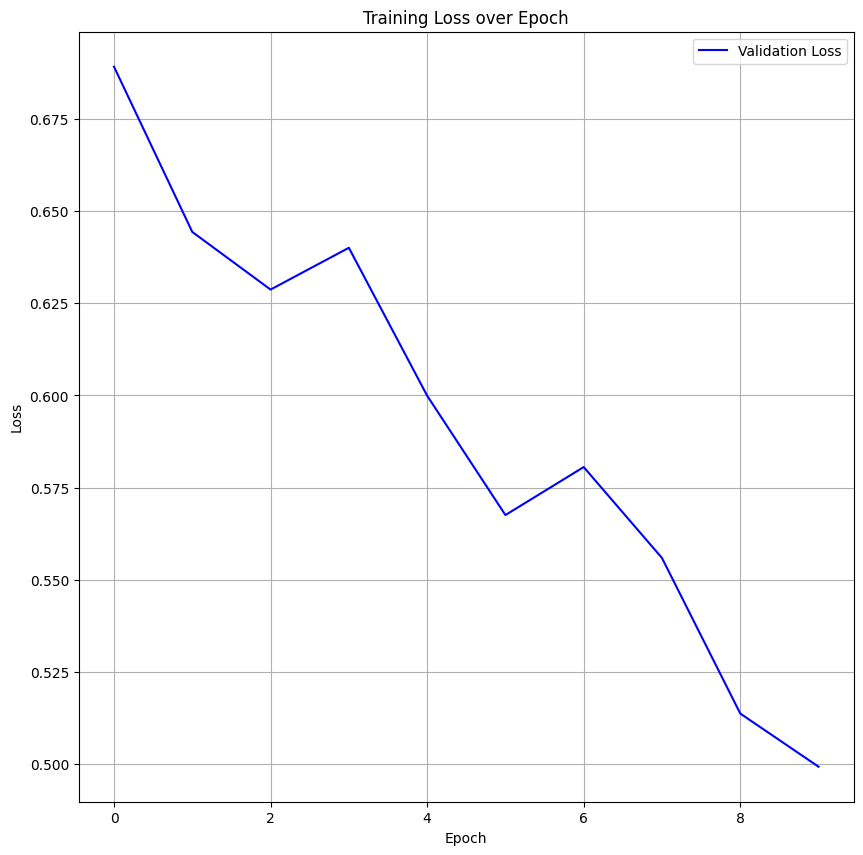

In [41]:
plt.figure(figsize=(10, 10))
plt.plot(rnn_training_losses, label='Validation Loss', color='blue')
plt.title("Training Loss over Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [15]:
# define our model class
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, gru1_hidden_size, gru2_hidden_size, dense_hidden_size, output_size, dropout_p=0.5):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout_embed = nn.Dropout(dropout_p)

        self.gru1 = nn.GRU(embedding_dim,
                           gru1_hidden_size,
                           num_layers=1,
                           batch_first=True,
                           bidirectional=True)
        self.dropout_gru1 = nn.Dropout(dropout_p)

        self.gru2 = nn.GRU(gru1_hidden_size * 2,
                           gru2_hidden_size,
                           num_layers=1,
                           batch_first=True,
                           bidirectional=True)
        self.dropout_gru2 = nn.Dropout(dropout_p)

        self.fc1 = nn.Linear(gru2_hidden_size * 2, dense_hidden_size)
        self.relu = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(dropout_p)

        # Final output layer
        self.fc2 = nn.Linear(dense_hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout_embed(x) # Shape: (batch_size, seq_len, embedding_dim)

        gru1_out, _ = self.gru1(x)
        gru1_out = self.dropout_gru1(gru1_out)

        _, hn_gru2 = self.gru2(gru1_out)

        hidden_combined = torch.cat((hn_gru2[0, :, :], hn_gru2[1, :, :]), dim=1)

        out_fc1 = self.fc1(hidden_combined)
        out_relu = self.relu(out_fc1)
        out_dropout_fc1 = self.dropout_fc1(out_relu)

        # Final output layer
        out = self.fc2(out_dropout_fc1) # Shape: (batch_size, output_size)
        return out

In [42]:
embedding_dim = 256
gru1_hidden_size = 128
gru2_hidden_size = 64
dense_hidden_size = 64
dropout_rate = 0.2

output_size = 2 # binary classification (remains the same)
learning_rate = 0.001 # Keep as is, or tune
epochs = 10  # Keep as is, or tune

# Instantiate the model with new parameters
gru_model = GRU(vocab_size,
            embedding_dim,
            gru1_hidden_size,
            gru2_hidden_size,
            dense_hidden_size,
            output_size,
            dropout_p=dropout_rate).to(device)
gru_training_losses, gru_val_losses = train_model(gru_model, epochs)

Epoch [1/10], Training Loss: 0.5550
Epoch [1/10], Validation Loss: 0.3824
Epoch [2/10], Training Loss: 0.3073
Epoch [2/10], Validation Loss: 0.3512
Epoch [3/10], Training Loss: 0.1999
Epoch [3/10], Validation Loss: 0.3166
Epoch [4/10], Training Loss: 0.1304
Epoch [4/10], Validation Loss: 0.3899
Epoch [5/10], Training Loss: 0.0882
Epoch [5/10], Validation Loss: 0.4319
Epoch [6/10], Training Loss: 0.0582
Epoch [6/10], Validation Loss: 0.4569
Epoch [7/10], Training Loss: 0.0431
Epoch [7/10], Validation Loss: 0.5582
Epoch [8/10], Training Loss: 0.0332
Epoch [8/10], Validation Loss: 0.5694
Epoch [9/10], Training Loss: 0.0269
Epoch [9/10], Validation Loss: 0.6792
Epoch [10/10], Training Loss: 0.0228
Epoch [10/10], Validation Loss: 0.6795
Training complete.


In [43]:
report = test_model(gru_model)
print(report)

Accuracy of the model on the test data: 86.41%
              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86     12500
    Positive       0.86      0.87      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



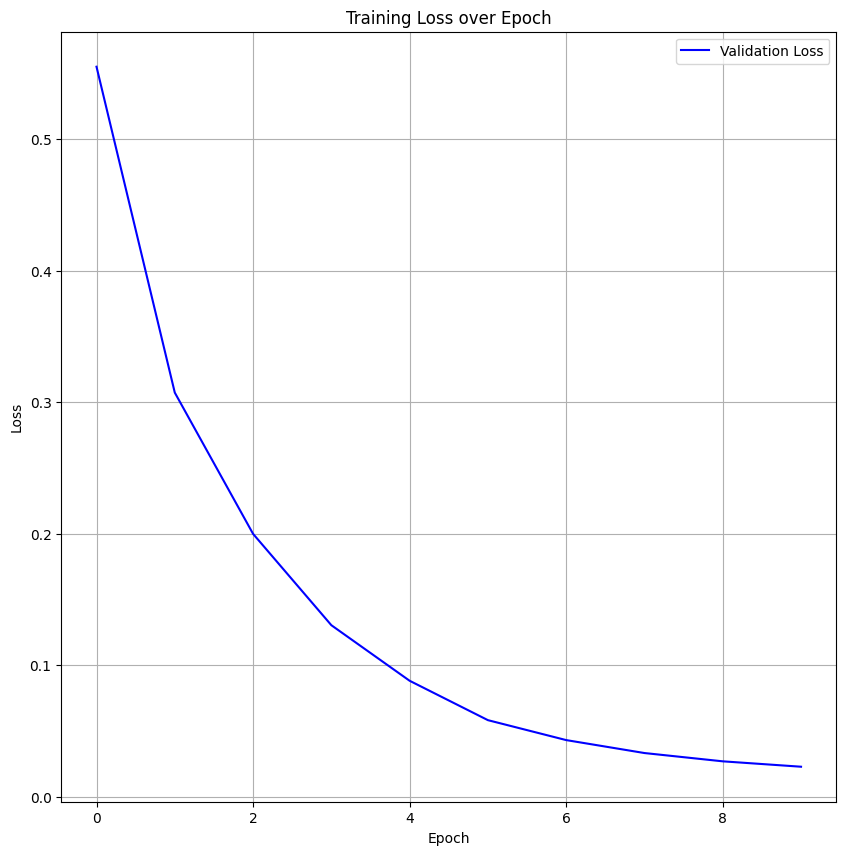

In [44]:
plt.figure(figsize=(10, 10))
plt.plot(gru_training_losses, label='Validation Loss', color='blue')
plt.title("Training Loss over Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# LSTM Model

In [30]:
# define our model class
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, lstm1_hidden_size, lstm2_hidden_size, dense_hidden_size, output_size, dropout_p=0.5):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout_embed = nn.Dropout(dropout_p)

        self.lstm1 = nn.LSTM(embedding_dim,
                             lstm1_hidden_size,
                             num_layers=1,
                             batch_first=True,
                             bidirectional=True)
        self.dropout_lstm1 = nn.Dropout(dropout_p)

        self.lstm2 = nn.LSTM(lstm1_hidden_size * 2,
                             lstm2_hidden_size,
                             num_layers=1,
                             batch_first=True,
                             bidirectional=True)
        self.dropout_lstm2 = nn.Dropout(dropout_p)

        self.fc1 = nn.Linear(lstm2_hidden_size * 2, dense_hidden_size)
        self.relu = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(dropout_p)

        # Final output layer
        self.fc2 = nn.Linear(dense_hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout_embed(x) # Shape: (batch_size, seq_len, embedding_dim)

        lstm1_out, _ = self.lstm1(x)
        lstm1_out = self.dropout_lstm1(lstm1_out)

        _, (hn_lstm2, cn_lstm2) = self.lstm2(lstm1_out)

        hidden_combined = torch.cat((hn_lstm2[0, :, :], hn_lstm2[1, :, :]), dim=1)

        out_fc1 = self.fc1(hidden_combined)
        out_relu = self.relu(out_fc1)
        out_dropout_fc1 = self.dropout_fc1(out_relu)

        # Final output layer
        out = self.fc2(out_dropout_fc1) # Shape: (batch_size, output_size)
        return out

In [31]:
embedding_dim = 256
lstm1_hidden_size = 128
lstm2_hidden_size = 64
dense_hidden_size = 64
dropout_rate = 0.2

output_size = 2 # binary classification (remains the same)
epochs = 10  # Keep as is, or tune

# Instantiate the model with new parameters
lstm_model = LSTM(vocab_size,
            embedding_dim,
            lstm1_hidden_size,
            lstm2_hidden_size,
            dense_hidden_size,
            output_size,
            dropout_p=dropout_rate).to(device)
training_losses, val_losses = train_model(lstm_model, epochs)

Epoch [1/10], Training Loss: 0.6330
Epoch [1/10], Validation Loss: 0.6203
Epoch [2/10], Training Loss: 0.4522
Epoch [2/10], Validation Loss: 0.4265
Epoch [3/10], Training Loss: 0.3326
Epoch [3/10], Validation Loss: 0.3690
Epoch [4/10], Training Loss: 0.2748
Epoch [4/10], Validation Loss: 0.3908
Epoch [5/10], Training Loss: 0.2266
Epoch [5/10], Validation Loss: 0.3937
Epoch [6/10], Training Loss: 0.1816
Epoch [6/10], Validation Loss: 0.4026
Epoch [7/10], Training Loss: 0.1411
Epoch [7/10], Validation Loss: 0.4267
Epoch [8/10], Training Loss: 0.1131
Epoch [8/10], Validation Loss: 0.4508
Epoch [9/10], Training Loss: 0.0816
Epoch [9/10], Validation Loss: 0.5180
Epoch [10/10], Training Loss: 0.0673
Epoch [10/10], Validation Loss: 0.6007
Training complete.


In [32]:
report = test_model(lstm_model)
print(report)

Accuracy of the model on the test data: 85.25%
              precision    recall  f1-score   support

    Negative       0.84      0.87      0.86     12500
    Positive       0.87      0.83      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



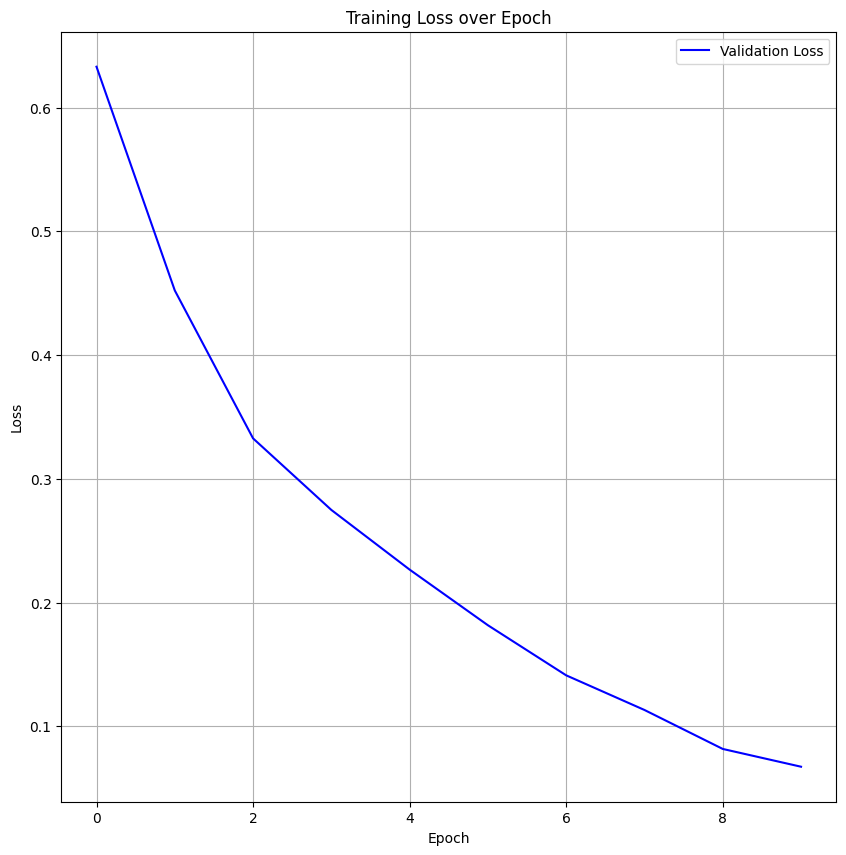

In [36]:
plt.figure(figsize=(10, 10))
plt.plot(training_losses, label='Validation Loss', color='blue')
plt.title("Training Loss over Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()